<a href="https://colab.research.google.com/github/RChandana/HLoc/blob/main/EuRoC_Mav_Demo_106.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd Hierarchical-Localization

# !git clone --quiet --recursive https://github.com/RChandana/HLoc/
# %cd HLoc

!pip install --progress-bar off --quiet -e .
!pip install --progress-bar off --quiet --upgrade plotly

import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

/content/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
images = Path('/content/Hierarchical-Localization/Dataset/EuRoC_Mav_New')

outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

In [ ]:
if not images.exists():
    # !wget https://github.com/RChandana/HLoc/blob/39f3db1203d5c4797f79d0a7bd624d86ebea5c7e/Dataset/KITTI_CAM_Images/KITTI_CAM_Images.zip -P Dataset/
    !unzip /content/EuRoC_Mav_New.zip -d Dataset/

106 mapping images


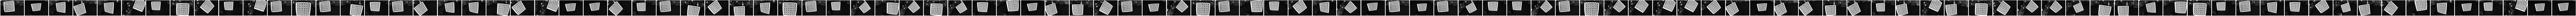

In [ ]:
references = [str(p.relative_to(images)) for p in (images).iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

In [ ]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/10/16 07:08:22 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /root/.cache/torch/hub/checkpoints/depth-save.pth


  0%|          | 0.00/4.17M [00:00<?, ?B/s]

  0%|          | 0/106 [00:00<?, ?it/s]

[2023/10/16 07:08:43 hloc INFO] Finished exporting features.
[2023/10/16 07:08:43 hloc INFO] Found 5565 pairs.
[2023/10/16 07:08:43 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/disk_lightglue.pth" to /root/.cache/torch/hub/checkpoints/disk_lightglue_v0-1_arxiv-pth


  0%|          | 0.00/45.4M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/5565 [00:00<?, ?it/s]

[2023/10/16 07:14:26 hloc INFO] Finished exporting matches.


In [ ]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2023/10/16 07:14:26 hloc INFO] Creating an empty database...
[2023/10/16 07:14:26 hloc INFO] Importing images into the database...
[2023/10/16 07:14:26 hloc INFO] Importing features into the database...


  0%|          | 0/106 [00:00<?, ?it/s]

[2023/10/16 07:14:26 hloc INFO] Importing matches into the database...


  0%|          | 0/5565 [00:00<?, ?it/s]

[2023/10/16 07:14:33 hloc INFO] Performing geometric verification of the matches...
[2023/10/16 07:15:37 hloc INFO] Running 3D reconstruction...
[2023/10/16 08:11:45 hloc INFO] Reconstructed 1 model(s).
[2023/10/16 08:11:45 hloc INFO] Largest model is #0 with 106 images.
[2023/10/16 08:11:45 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 106
	num_cameras = 106
	num_points3D = 5387
	num_observations = 201157
	mean_track_length = 37.3412
	mean_observations_per_image = 1897.71
	mean_reprojection_error = 1.24819
	num_input_images = 106


In [ ]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

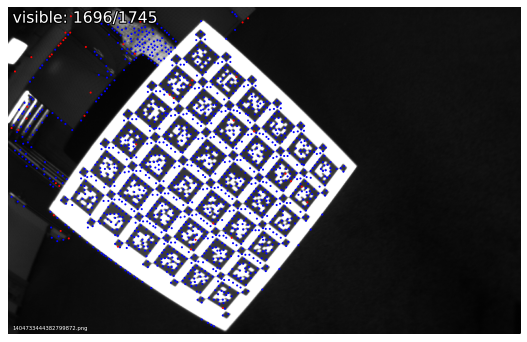

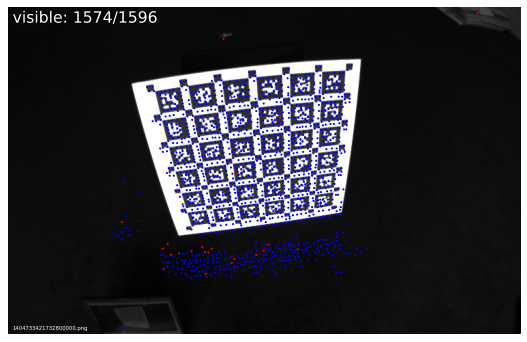

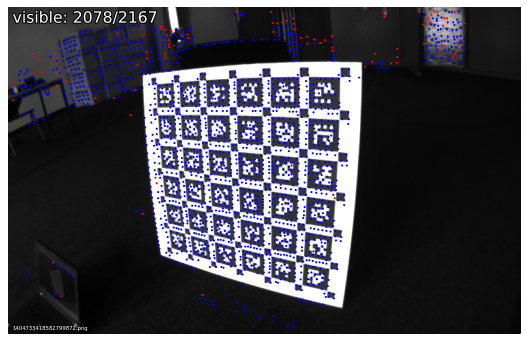

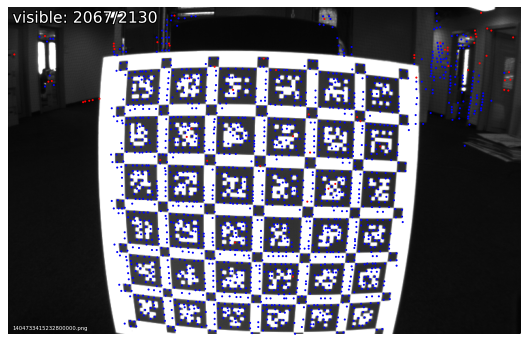

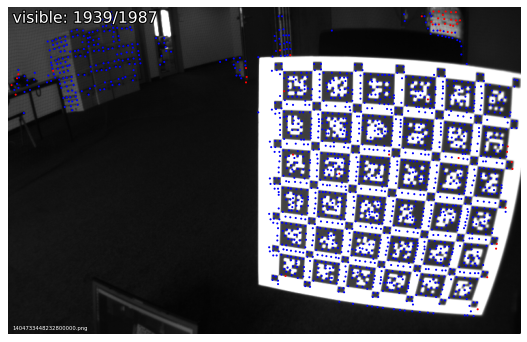

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=5)

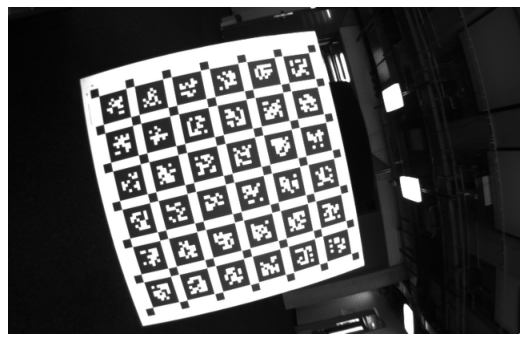

In [ ]:
url = "https://i.ibb.co/F68kFTF/1404733476682800128.png"
query = 'query/night.jpg'
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

In [ ]:
references_registered = [model.images[i].name for i in model.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2023/10/16 08:11:49 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/10/16 08:11:49 hloc INFO] Finished exporting features.
[2023/10/16 08:11:49 hloc INFO] Found 106 pairs.
[2023/10/16 08:11:49 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  0%|          | 0/106 [00:00<?, ?it/s]

[2023/10/16 08:11:58 hloc INFO] Finished exporting matches.


found 4003/8536 inlier correspondences.


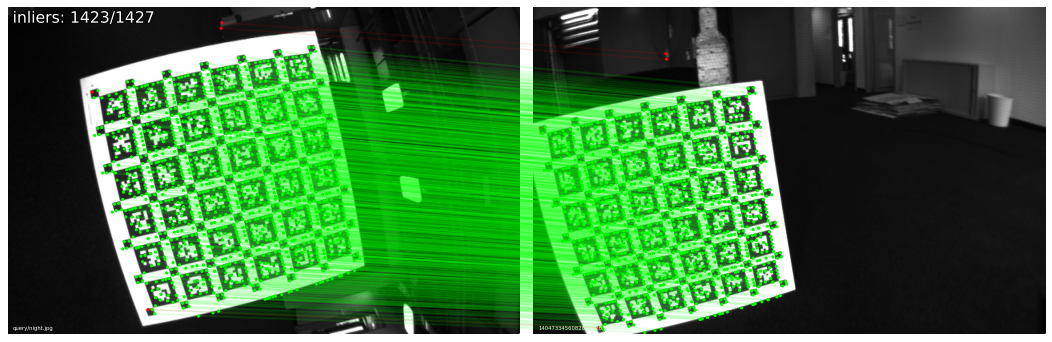

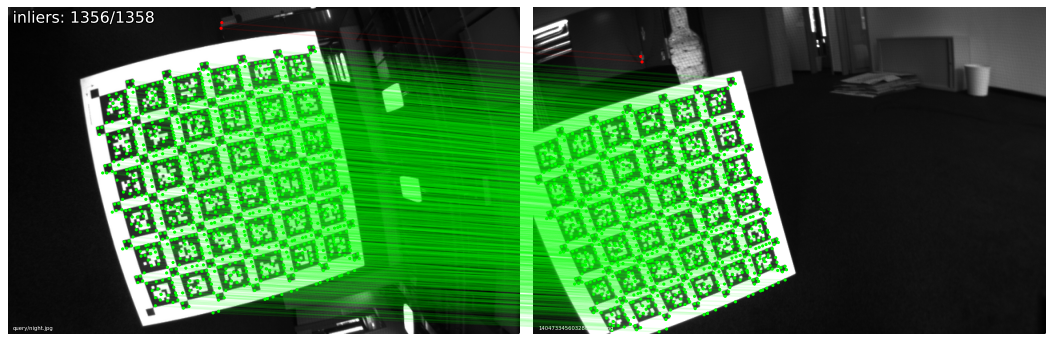

In [ ]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

In [ ]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
import numpy as np
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()